# Adaptive stopping in a Bandit problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from compare_agents import MultipleAgentsComparator, Two_AgentsComparator

from rlberry.agents.torch import DQNAgent, PPOAgent, A2CAgent
from rlberry.agents import RSUCBVIAgent
import pandas as pd

from rlberry.envs.bandits import BernoulliBandit
from rlberry.wrappers import WriterWrapper
from rlberry.agents.bandits import (
    IndexAgent,
    RandomizedAgent,
    makeBoundedIMEDIndex,
    makeBoundedMOSSIndex,
    makeBoundedNPTSIndex,
    makeBoundedUCBIndex,
    makeETCIndex,
)



We wish to reproduce the results in https://rlberry.readthedocs.io/en/latest/auto_examples/demo_bandits/plot_compare_index_bandits.html#sphx-glr-auto-examples-demo-bandits-plot-compare-index-bandits-py


## Problem setting

In [2]:
# Parameters of the problem
means = np.array([0.6, 0.6, 0.6, 0.9])  # means of the arms
A = len(means)
T = 2000  # Horizon

# Construction of the experiment

env_ctor = BernoulliBandit
env_kwargs = {"p": means}


class UCBAgent(IndexAgent):
    name = "UCB"

    def __init__(self, env, **kwargs):
        index, _ = makeBoundedUCBIndex()
        IndexAgent.__init__(self, env, index, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="reward"
        )
    


class ETCAgent(IndexAgent):
    name = "ETC"

    def __init__(self, env, m=20, **kwargs):
        index, _ = makeETCIndex(A, m)
        IndexAgent.__init__(self, env, index, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="action_and_reward"
        )

        
class MOSSAgent(IndexAgent):
    name = "MOSS"

    def __init__(self, env, **kwargs):
        index, _ = makeBoundedMOSSIndex(T, A)
        IndexAgent.__init__(self, env, index, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="action_and_reward"
        )


class IMEDAgent(IndexAgent):
    name = "IMED"

    def __init__(self, env, **kwargs):
        index, tracker_params = makeBoundedIMEDIndex()
        IndexAgent.__init__(self, env, index, tracker_params=tracker_params, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="reward"
        )

class NPTSAgent(IndexAgent):
    name = "NPTS"

    def __init__(self, env, **kwargs):
        index, tracker_params = makeBoundedNPTSIndex()
        IndexAgent.__init__(self, env, index, tracker_params=tracker_params, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="reward"
        )


Agents_class = [
    MOSSAgent,
    IMEDAgent,
    NPTSAgent,
    UCBAgent,
    ETCAgent
]

managers = [
    (Agent,
        dict(
        train_env=(env_ctor, env_kwargs),
        fit_budget=T,
        parallelization="process",
        mp_context="fork")
    )
    for Agent in Agents_class
]


## Adastop algorithm

In [3]:
# we want to be able to see a difference of 5 and the std is around 10
n = 10
K = 10
B=10000
alpha = 0.05

In [4]:

n_managers = len(managers)
print('With these parameters, we have a maximum of {} fits done for each agent'.format(n*K))
print('Number of comparisons is {}'.format(n_managers*(n_managers-1)/2))

With these parameters, we have a maximum of 100 fits done for each agent
Number of comparisons is 10.0


let us now compare all the different algorithm

In [5]:
from rlberry.utils.logging import set_level
set_level('ERROR')

In [6]:
class Comparator(MultipleAgentsComparator):
    def __init__(self, **kwargs):
        MultipleAgentsComparator.__init__(self, **kwargs)
        
    def _get_evals(self, manager):
        """
        Compute the cumulative reward.
        """
        eval_values = []
        for idx in  manager.get_writer_data():
            df = manager.get_writer_data()[idx]
            eval_values.append(np.sum(np.max(means)-df.loc[df['tag']=='reward', 'value']))
        return eval_values

In [7]:
comparator  = Comparator(n=n, K=K, B=B, alpha=alpha, n_evaluations = 10, beta=0.01)

comparator.compare(managers)

print(comparator.decisions,
      comparator.comparisons,
      comparator.rejected_decision)

Step 0
reject
Step 1
reject
reject
reject
reject
Step 2
Step 3
reject
Step 4
reject
Step 5
Step 6
Step 7
Step 8
Step 9
['reject' 'reject' 'reject' 'reject' 'accept' 'reject' 'accept' 'reject'
 'accept' 'reject'] [[0 1]
 [0 2]
 [0 3]
 [0 4]
 [1 2]
 [1 3]
 [1 4]
 [2 3]
 [2 4]
 [3 4]] [array([1, 3]), array([3, 4]), array([2, 3]), array([0, 3]), array([0, 1]), array([0, 4]), array([0, 2])]


We reject the comparisons (1,3), (0,1), (0,2) , (2,3) and (0,3). Let us check graphically that this makes sense

In [8]:
comparator.eval_values

[array([ 6., 32., 23., 13., 17., 42., 25., 33., 13., 38., 13., 23., 34.,
        25., 26., 35., 25., 31., -1., 42., -1., 47., 46., 40., 45., 27.,
        38., 31., 54., 52., 12., 21., 46., 37., 23., 38., 51., 21., 33.,
        21., 31., 25., 19., 17.,  2., 35., 34., 36., 45., 34.]),
 array([ 1.00000000e+00,  6.00000000e+00,  2.90000000e+01,  2.00000000e+00,
        -1.71207493e-12,  1.10000000e+01,  2.90000000e+01,  7.00000000e+00,
         2.00000000e+01, -1.00000000e+00,  3.80000000e+01, -1.00000000e+00,
        -2.10000000e+01,  1.60000000e+01,  1.90000000e+01,  3.20000000e+01,
         1.50000000e+01, -6.00000000e+00,  1.60000000e+01, -6.00000000e+00,
         9.00000000e+00,  1.80000000e+01,  1.70000000e+01,  3.60000000e+01,
         1.70000000e+01,  1.00000000e+01,  4.00000000e+00,  2.40000000e+01,
         2.50000000e+01,  2.20000000e+01,  2.00000000e+01,  3.40000000e+01,
         2.80000000e+01, -1.30000000e+01,  1.60000000e+01,  1.10000000e+01,
         1.30000000e+01,  1.5000

In [9]:
id_sort = np.argsort(comparator.mean_eval_values)
Z = [ comparator.eval_values[f] for f in id_sort]

/home/frost/code/Adaptive_stopping_MC_RL/code/compare_agents.py:982: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Z = np.array(self.eval_values)[id_sort]


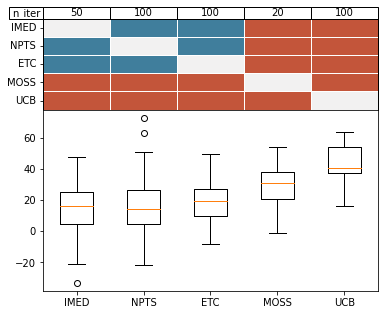

In [10]:
comparator.plot_results(['MOSS','IMED','NPTS','UCB','ETC'])